In [38]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [39]:
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-west-2 region. You will use the 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [40]:
bucket_name = 'vengalarao-1' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [41]:
import pandas as pd
import urllib
# try:
#     urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
#     print('Success: downloaded bank_clean.csv.')
# except Exception as e:
#     print('Data load error: ',e)

try:
    data = pd.read_csv('train-1.csv')
    data2 = pd.read_csv('test-2.csv')
    print('Success: Data loaded into dataframe.')
    data.head()
except Exception as e:
    print('Data load error: ',e)
    
# try:
#     data2 = pd.read_csv('test-2.csv',index_col=0)
#     print('Success: Data2 loaded into dataframe.')
#     data2.head()
# except Exception as e:
#     print('Data load error: ',e)

Success: Data loaded into dataframe.


In [42]:
new_df=pd.concat([data,data2])

In [46]:
df=new_df

In [47]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].mean())
df.drop(['Alley'],axis=1,inplace=True)
df['BsmtCond']=df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])
df['BsmtQual']=df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
df['FireplaceQu']=df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])
df['GarageType']=df['GarageType'].fillna(df['GarageType'].mode()[0])
df.drop(['GarageYrBlt'],axis=1,inplace=True)
df['GarageFinish']=df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])
df['GarageQual']=df['GarageQual'].fillna(df['GarageQual'].mode()[0])
df['GarageCond']=df['GarageCond'].fillna(df['GarageCond'].mode()[0])
df.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
#df.drop(['Id'],axis=1,inplace=True)
df['MasVnrType']=df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])
df['BsmtExposure']=df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
df['BsmtFinType2']=df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])
df.dropna(inplace=True)

KeyError: "['Alley'] not found in axis"

<AxesSubplot:>

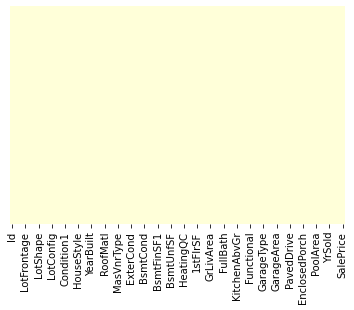

In [48]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')

In [49]:
from sklearn.preprocessing import label_binarize,LabelEncoder

In [50]:
cat_bf=df.select_dtypes(exclude=np.number)
cat_bf.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [51]:
lb=LabelEncoder()
for i in cat_bf.columns:
    df[i]=lb.fit_transform(np.array(df[i]).reshape(-1,1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [52]:
train_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df))])
print(train_data.shape, test_data.shape)

(995, 76) (427, 76)


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1422 non-null   int64  
 1   MSSubClass     1422 non-null   int64  
 2   MSZoning       1422 non-null   int64  
 3   LotFrontage    1422 non-null   float64
 4   LotArea        1422 non-null   int64  
 5   Street         1422 non-null   int64  
 6   LotShape       1422 non-null   int64  
 7   LandContour    1422 non-null   int64  
 8   Utilities      1422 non-null   int64  
 9   LotConfig      1422 non-null   int64  
 10  LandSlope      1422 non-null   int64  
 11  Neighborhood   1422 non-null   int64  
 12  Condition1     1422 non-null   int64  
 13  Condition2     1422 non-null   int64  
 14  BldgType       1422 non-null   int64  
 15  HouseStyle     1422 non-null   int64  
 16  OverallQual    1422 non-null   int64  
 17  OverallCond    1422 non-null   int64  
 18  YearBuil

In [54]:
pd.concat([train_data['SalePrice'], train_data.drop(['SalePrice'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [55]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [56]:
xgb.fit({'train': s3_input_train})

2022-05-14 07:42:02 Starting - Starting the training job...ProfilerReport-1652514122: InProgress
...
2022-05-14 07:42:46 Starting - Preparing the instances for training......
2022-05-14 07:44:02 Downloading - Downloading input data......
2022-05-14 07:44:48 Training - Downloading the training image.....Arguments: train
[2022-05-14:07:45:43:INFO] Running standalone xgboost training.
[2022-05-14:07:45:43:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-05-14:07:45:43:INFO] File size need to be processed in the node: 0.21mb. Available memory size in the node: 8467.22mb
[2022-05-14:07:45:43:INFO] Determined delimiter of CSV input is ','
[07:45:43] S3DistributionType set as FullyReplicated
[07:45:43] 995x75 matrix with 74625 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-05-14:07:45:43:ERROR] Customer Error: Label must be in [0,1] for logistic regression task. If input is in csv format, ensure the first column is the label.
Traceback (

UnexpectedStatusException: Error for Training job xgboost-2022-05-14-07-42-02-141: Failed. Reason: ClientError: Label must be in [0,1] for logistic regression task. If input is in csv format, ensure the first column is the label., exit code: 1